Optimal transport cost: 0.9000
Optimal transport plan P (rows = source i, cols = target j):
[[4.00000000e-01 0.00000000e+00 0.00000000e+00]
 [9.99999999e-02 2.00000000e-01 1.00000000e-01]
 [0.00000000e+00 1.47134804e-10 2.00000000e-01]]


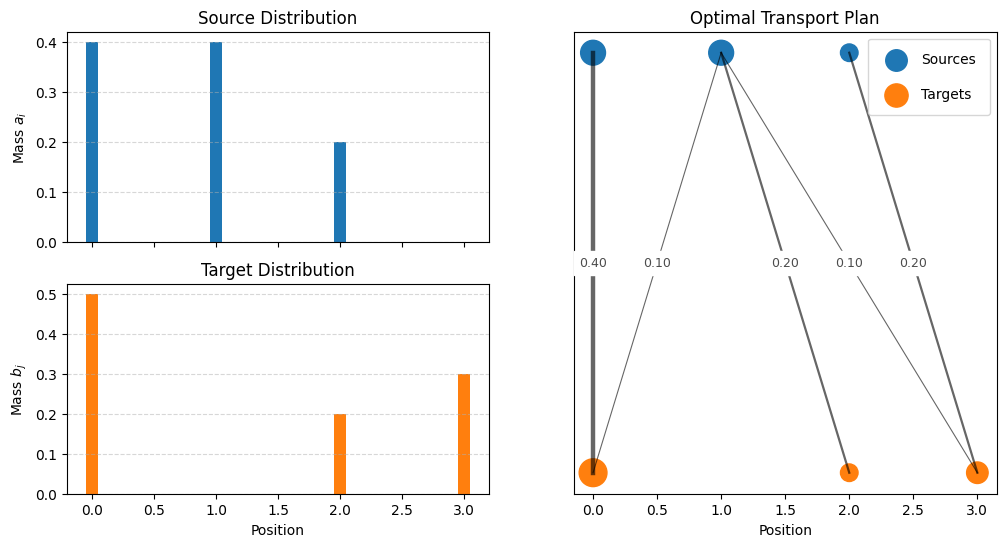

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define two discrete probability distributions (source a, target b)
#    Here we have 3 source locations and 3 target locations.
a = np.array([0.4, 0.4, 0.2])   # source weights (must sum to 1)
b = np.array([0.5, 0.2, 0.3])   # target weights (must sum to 1)

# Assign positions on the real line to each point
x = np.array([0.0, 1.0, 2.0])   # source locations
y = np.array([0.0, 2.0, 3.0])   # target locations

# Build the cost matrix C_ij = |x_i - y_j|^2
C = (x[:, None] - y[None, :])**2

# Create the transport‐plan variable P ∈ ℝ^{3×3}, P ≥ 0
P = cp.Variable(C.shape, nonneg=True)

# Impose the marginals:
#   - Sum over rows i of P[i,j] == b[j]  (each target mass is matched)
#   - Sum over cols j of P[i,j] == a[i]  (all source mass is shipped)
constraints = [
    cp.sum(P, axis=1) == a,
    cp.sum(P, axis=0) == b
]

# Objective: minimize total cost ∑_{i,j} C[i,j] * P[i,j]
objective = cp.Minimize(cp.sum(cp.multiply(C, P)))

# Solve the linear program
prob = cp.Problem(objective, constraints)
opt_cost = prob.solve()

print(f"Optimal transport cost: {opt_cost:.4f}")
print("Optimal transport plan P (rows = source i, cols = target j):")
print(P.value)

# --- Combined visualization in one window ---
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# Top‐left: source distribution (hide its x‐tick labels to avoid clutter)
ax_src = fig.add_subplot(gs[0, 0])
ax_src.bar(x, a, width=0.1, align='center')
ax_src.set_title("Source Distribution")
ax_src.set_ylabel("Mass $a_i$")
ax_src.grid(axis='y', linestyle='--', alpha=0.5)
ax_src.tick_params(labelbottom=False)              # hide x‐labels here

# Bottom‐left: target distribution, sharing x-axis with source
ax_tgt = fig.add_subplot(gs[1, 0], sharex=ax_src)
ax_tgt.bar(y, b, width=0.1, align='center', color='C1')
ax_tgt.set_title("Target Distribution")
ax_tgt.set_xlabel("Position")
ax_tgt.set_ylabel("Mass $b_j$")
ax_tgt.grid(axis='y', linestyle='--', alpha=0.5)

# Right (spanning both rows): flow diagram
ax_flow = fig.add_subplot(gs[:, 1])
for i in range(len(x)):
    for j in range(len(y)):
        w = P.value[i, j]
        if w > 1e-8:
            ax_flow.plot([x[i], y[j]], [1, 0],
                         linewidth=8 * w, color='black', alpha=0.6)
            mx = (x[i] + y[j]) / 2 # label at midpoint
            ax_flow.text(mx, 0.5, f"{w:.2f}",
                         fontsize=9, ha='center', va='center',
                         backgroundcolor='white', alpha=0.7)


# draw source/target nodes
ax_flow.scatter(x, np.ones_like(x), s=800 * a, c='C0', label='Sources')
ax_flow.scatter(y, np.zeros_like(y), s=800 * b, c='C1', label='Targets')
ax_flow.set_yticks([])
ax_flow.set_xlabel("Position")
ax_flow.set_title("Optimal Transport Plan")
ax_flow.legend(loc='upper right', labelspacing=1.5, borderpad=1.0)

plt.show()